# Data Science at IGFAE 2024
## Lesson 1

## Pietro Vischia (Universidad de Oviedo and ICTEA), pietro.vischia@cern.ch

In [1]:
# Uncomment and run this if you are running on Colab (remove only the "#", keep the "!").
# You can run it anyway, but it will do nothing if you have already installed all dependencies
# (and it will take some time to tell you it is not gonna do anything)


#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/MyDrive/"
#! git clone https://github.com/vischia/data_science_school_igfae2024.git
#%cd machine_learning_tutorial
#!pwd
#!ls
#!pip install livelossplot shap

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import re
import math
import socket
import json
import pickle
import gzip
import copy
import array
import numpy as np
import numpy.lib.recfunctions as recfunc

from scipy.optimize import newton
from scipy.stats import norm

import uproot

import datetime
from timeit import default_timer as timer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
try:
    # See #1137: this allows compatibility for scikit-learn >= 0.24
    from sklearn.utils import safe_indexing
except ImportError:
    from sklearn.utils import _safe_indexing
    
from livelossplot import PlotLossesKeras

from keras.losses import mean_squared_error, binary_crossentropy
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Concatenate
from keras.layers import Lambda, Activation
from keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import Adam # for macos
# from keras.optimizers import Adam # for non-macos
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU

import keras
from keras import backend as K
import tensorflow as tf
import pandas as pd

import shap
shap.initjs()


# Import data

We will use simulated events corresponding to three physics processes.

- ttH production
- ttW production
- Drell-Yan production

We will select the multilepton final state, which is a challenging final state with a rich structure and nontrivial background separation.

<img src="figs/2lss.png" alt="ttH multilepton 2lss" style="width:40%;"/>


In [3]:
INPUT_FOLDER = './'
HAVE_GPU = True
# Uncomment this if you haven't installed the data yet
#!cd data/; wget https://www.hep.uniovi.es/vischia/cmsdas2024/ft_tth_multilep_igfae2024.tar.gz; tar xzvf ft_tth_multilep_igfae2024.tar.gz; mv igfae2024/* .; rmdir igfae2024; rm ft_tth_multilep_igfae2024.tar.gz; cd -;

In [4]:
import uproot
sig = uproot.open('data/signal.root')['Friends'].arrays(library="pd")
bk1 = uproot.open('data/background_1.root')['Friends'].arrays(library="pd")
bk2 = uproot.open('data/background_2.root')['Friends'].arrays(library="pd")


## Data inspection

The first thing you need to do when building a machine learning model is to forget about the model, and **just look at the data**

In [5]:
sig.head()

,Hreco_Lep0_pt,Hreco_Lep1_pt,Hreco_Lep2_pt,Hreco_HadTop_pt,Hreco_All5_Jets_pt,Hreco_More5_Jets_pt,Hreco_Jets_plus_Lep_pt,Hreco_Lep0_eta,Hreco_Lep1_eta,Hreco_Lep2_eta,...,Hreco_HadTop_mass,Hreco_All5_Jets_mass,Hreco_More5_Jets_mass,Hreco_Jets_plus_Lep_mass,Hreco_TopScore,Hreco_met,Hreco_met_phi,Hreco_HTXS_Higgs_pt,Hreco_HTXS_Higgs_y,Hreco_evt_tag
0,155.774521,115.399506,-99.0,223.959366,60.545536,-99.000000,38.659439,0.704956,1.740967,-99.0,...,117.884277,797.855957,-99.000000,1110.568970,0.698709,53.674736,1.805908,198.085938,0.907349,1.0
1,17.504662,13.544321,-99.0,-99.000000,34.523201,-99.000000,49.515820,-1.358154,-0.209381,-99.0,...,-99.000000,77.040558,-99.000000,113.121712,-100.000000,52.277988,-1.724121,51.763672,-0.843506,1.0
2,78.779388,52.155823,-99.0,277.231750,235.284637,32.206158,147.022125,-0.158020,-1.546143,-99.0,...,189.349594,402.740417,7.144531,728.448669,0.928701,134.958344,-1.216797,98.140625,-0.194122,1.0
3,10.800194,12.849953,-99.0,-99.000000,8.538654,-99.000000,21.128649,0.934692,0.146362,-99.0,...,-99.000000,285.434387,-99.000000,316.456085,-100.000000,47.660393,1.861328,84.867188,1.409424,1.0
4,23.966722,29.325552,-99.0,76.074242,120.810616,-99.000000,102.202065,0.992065,1.264893,-99.0,...,191.655838,403.657410,-99.000000,518.758850,0.226972,67.858330,-0.554199,51.496094,0.384033,1.0


Let's look in more detail at which features we have

In [6]:
print(sig.columns)

Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_Lep2_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_Lep2_eta',
       'Hreco_HadTop_eta', 'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_Lep2_phi', 'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi',
       'Hreco_More5_Jets_phi', 'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass',
       'Hreco_Lep1_mass', 'Hreco_Lep2_mass', 'Hreco_HadTop_mass',
       'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi', 'Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y',
       'Hreco_evt_tag'],
      dtype='object')


We can plot a variable

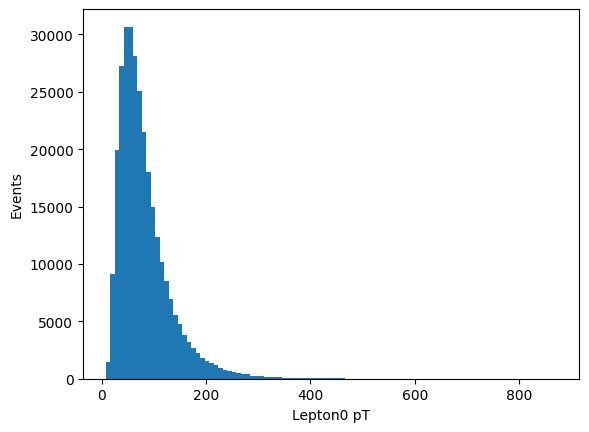

In [7]:
plt.hist(sig["Hreco_Lep0_pt"], bins=100)
plt.xlabel("Lepton0 pT")
plt.ylabel("Events")
plt.show()

We can plot one vs the other

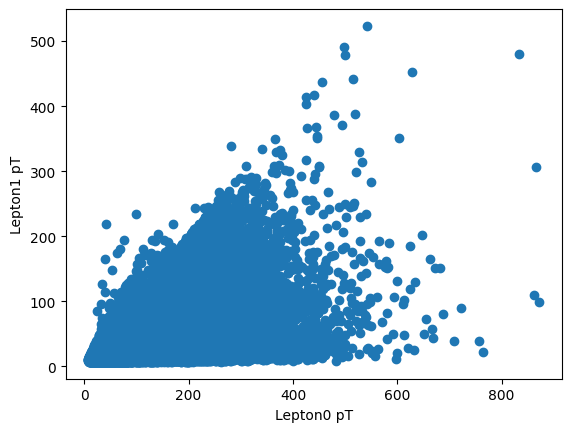

In [8]:
plt.scatter(sig["Hreco_Lep0_pt"], sig["Hreco_Lep1_pt"])
plt.xlabel("Lepton0 pT")
plt.ylabel("Lepton1 pT")
plt.show()

...and another one

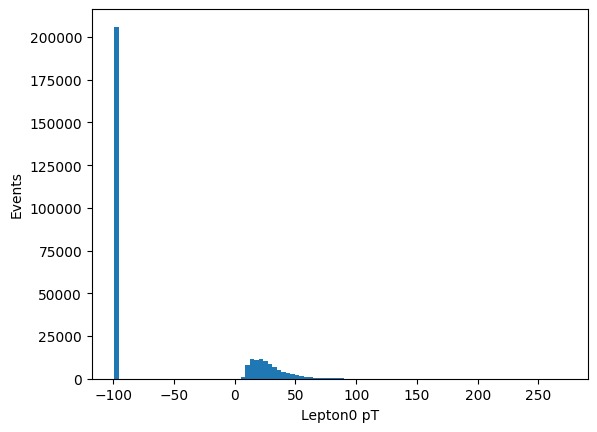

In [9]:
plt.hist(sig["Hreco_Lep2_pt"], bins=100)
plt.xlabel("Lepton0 pT")
plt.ylabel("Events")
plt.show()

**What is going on there???**

Let's also check that "event tag" variable

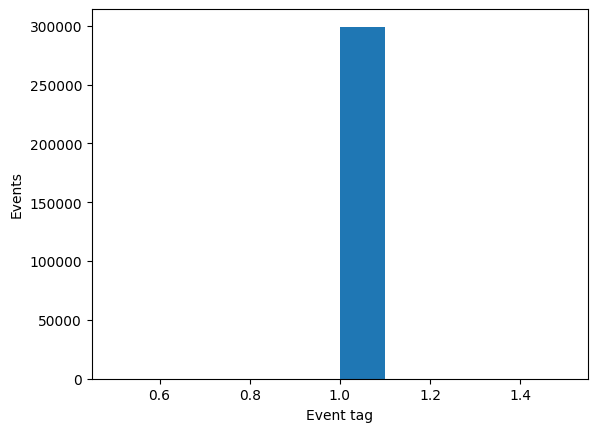

In [10]:
plt.hist(sig["Hreco_evt_tag"])
plt.xlabel("Event tag")
plt.ylabel("Events")
plt.show()

What could we do?

In [11]:
signal = sig.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag"], axis=1 )
signal.columns

Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi', 'Hreco_HTXS_Higgs_pt', 'Hreco_HTXS_Higgs_y'],
      dtype='object')

Now we need to drop two more features, that are actually generation-level features (we will use them for regression tomorrow)

In [12]:
signal = signal.drop(["Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
signal.columns

Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi'],
      dtype='object')

Let's also do the same for the backgrounds

In [13]:
bkg1 = bk1.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
bkg2 = bk2.drop(["Hreco_Lep2_pt", "Hreco_Lep2_eta", "Hreco_Lep2_phi", "Hreco_Lep2_mass", "Hreco_evt_tag","Hreco_HTXS_Higgs_pt", "Hreco_HTXS_Higgs_y"], axis=1 )
print(bkg2.columns)


Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi'],
      dtype='object')


Now let's put it all together, assigning some class labels. Let's start with signal and one background:

In [14]:
signal['label'] = 1
print(bkg1.shape, bkg2.shape)
bkg = pd.concat([bkg1, bkg2])
bkg['label'] = 0
print(bkg.shape)
data = pd.concat([signal,bkg]).sample(frac=1).reset_index(drop=True)

print(bkg.columns)
print(data.isna().any())

X = data.drop(["label"], axis=1)
y = data["label"]

print(data.shape, X.shape, y.shape)

(556648, 27) (1034904, 27)
(1591552, 28)
Index(['Hreco_Lep0_pt', 'Hreco_Lep1_pt', 'Hreco_HadTop_pt',
       'Hreco_All5_Jets_pt', 'Hreco_More5_Jets_pt', 'Hreco_Jets_plus_Lep_pt',
       'Hreco_Lep0_eta', 'Hreco_Lep1_eta', 'Hreco_HadTop_eta',
       'Hreco_All5_Jets_eta', 'Hreco_More5_Jets_eta',
       'Hreco_Jets_plus_Lep_eta', 'Hreco_Lep0_phi', 'Hreco_Lep1_phi',
       'Hreco_HadTop_phi', 'Hreco_All5_Jets_phi', 'Hreco_More5_Jets_phi',
       'Hreco_Jets_plus_Lep_phi', 'Hreco_Lep0_mass', 'Hreco_Lep1_mass',
       'Hreco_HadTop_mass', 'Hreco_All5_Jets_mass', 'Hreco_More5_Jets_mass',
       'Hreco_Jets_plus_Lep_mass', 'Hreco_TopScore', 'Hreco_met',
       'Hreco_met_phi', 'label'],
      dtype='object')
Hreco_Lep0_pt               False
Hreco_Lep1_pt               False
Hreco_HadTop_pt             False
Hreco_All5_Jets_pt          False
Hreco_More5_Jets_pt         False
Hreco_Jets_plus_Lep_pt      False
Hreco_Lep0_eta              False
Hreco_Lep1_eta              False
Hreco_HadTop_eta 

### Split the data set into training and test set

When we train a machine learning algorithm, we are trying to solve an interpolation problem (*find the function of the input features that provides the best approximation of the true function*) by also requiring that the solution generalizes sufficiently well (*the interpolating function must also predict correctly the value of the true function for new, unseen data*).


When we have a labelled dataset, we will therefore split it into: a *training set*, which we will use to train the machine learning algorithm; a *test set*, which we will use to evaluate the performance of the algorithm for various realizations of the algorithm (e.g. tuning hyperparameters); and an *application set*, which are the data we are really interested in studying in the end.

For many applications, when the amount of hyperparameters tuning is moderate, application set and test set can be collapsed into a single set (usually called *test set*). This is what we will do in this tutorial.

![Blah](figs/trainingNetwork.png)

(Image: P. Vischia, [doi:10.5281/zenodo.6373442](https://doi.org/10.5281/zenodo.6373442))

For the data set that we have loaded, we don't need to do any splitting, because the data set is already split into a training and test dataset.

If our data set needed to be split, we would have to split it. Libraries like `scikit-learn` provide some ready-made functions that just do that:



In [50]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)


print("We have", len(X_train), "training samples and ", len(X_test), "testing samples")

<class 'pandas.core.frame.DataFrame'>
We have 1266862 training samples and  623977 testing samples


### Inspect the data set

The first and most important thing to do, when developing a ML application, is to inspect the data set.

Looking at the data is crucial, because it may reveal the presence of malformed or missing data (e.g. when one feature has been filled with meaningless values for some or all of the data points) and may hint at whether it is necessary to preprocess the data.

In [16]:
# Visualize dataset

import seaborn as sns
sns.set()

0.13.2


NameError: name 'train_set' is not defined

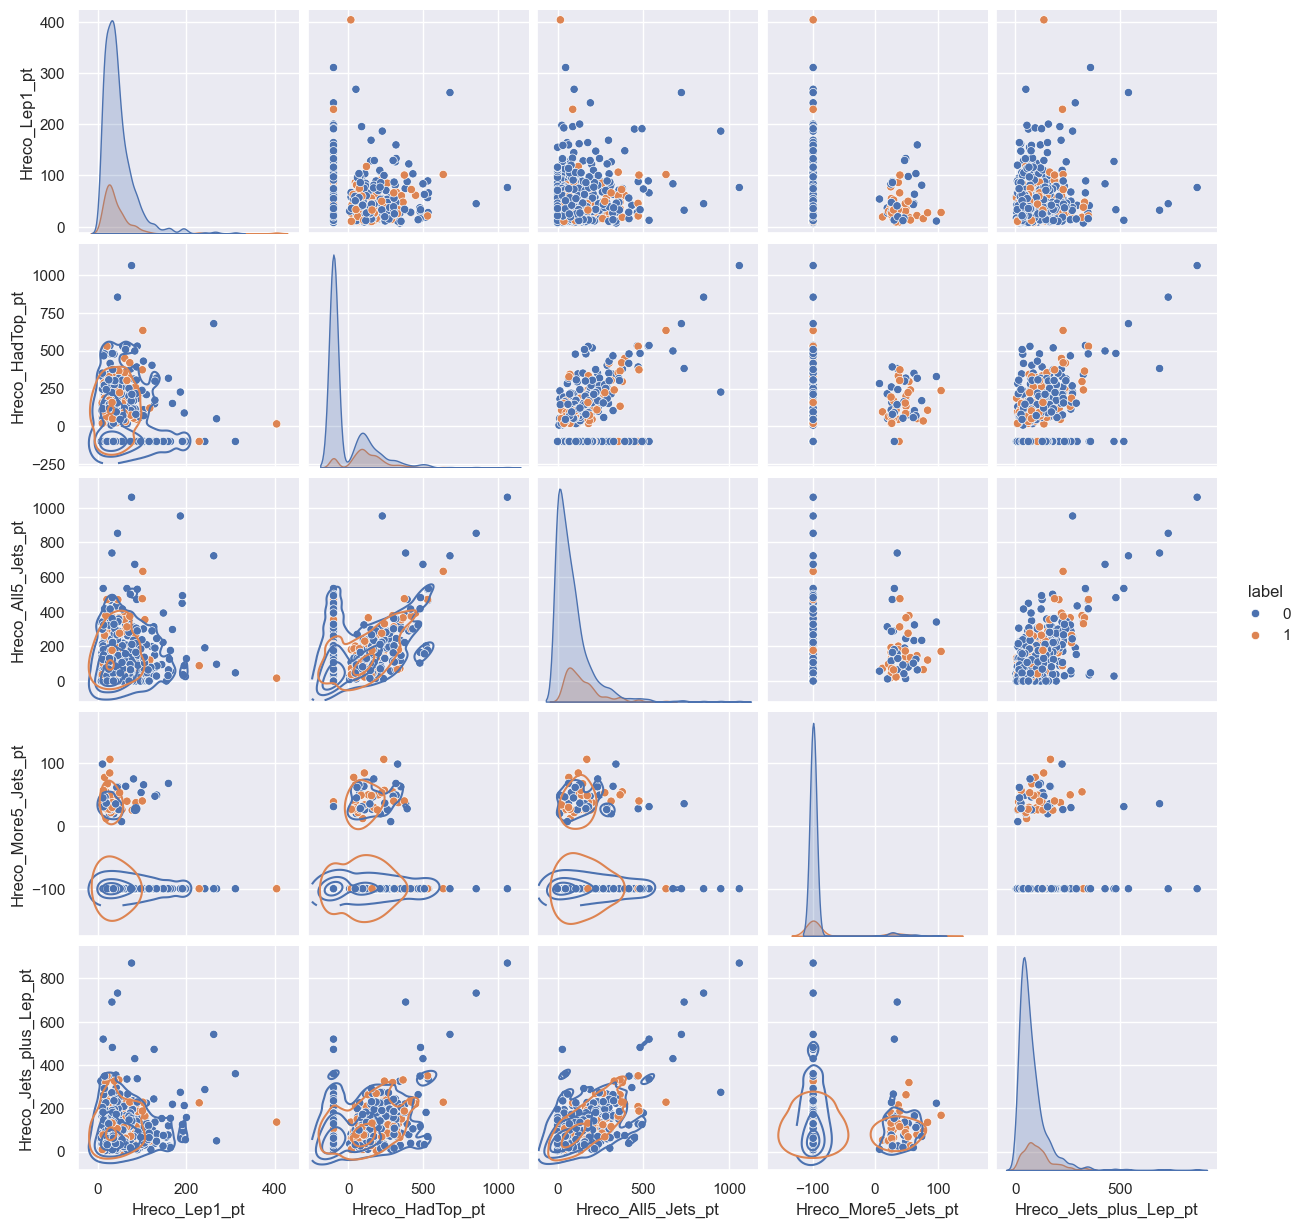

In [27]:
print(sns.__version__)

cols_to_plot = data.columns[1:6].tolist()
cols_to_plot.append("label")
pp=sns.pairplot(data=data.sample(1000)[cols_to_plot], hue='label', diag_kws={'bw_method': 0.2})
pp.map_lower(sns.kdeplot, levels=4, color=".2") # Contours
sns.pairplot(X_train.sample(100))
plt.show()

Exercise: what happens if you omit `.sample(100)` from the command above?

In [126]:
#pp=sns.pairplot(data=train_set[cols_to_plot], hue='label', diag_kws={'bw': 0.2})
#pp.map_lower(sns.kdeplot, levels=4, color=".2")
#plt.show()

#### Correlation matrices

For classification problems, another important thing to take a look at is the correlation matrix between all the variables, in events belonging to each class separately.

Looking at the correlation between features can highlight features that are strongly correlated with other ones, leading sometimes to dropping them ("*if they are almost fully correlated, then including both does not add new information*").

We look at the correlation for each class because we are very interested in pairs of features that have different correlation in one class or the other (in our example, signal or backgroun).

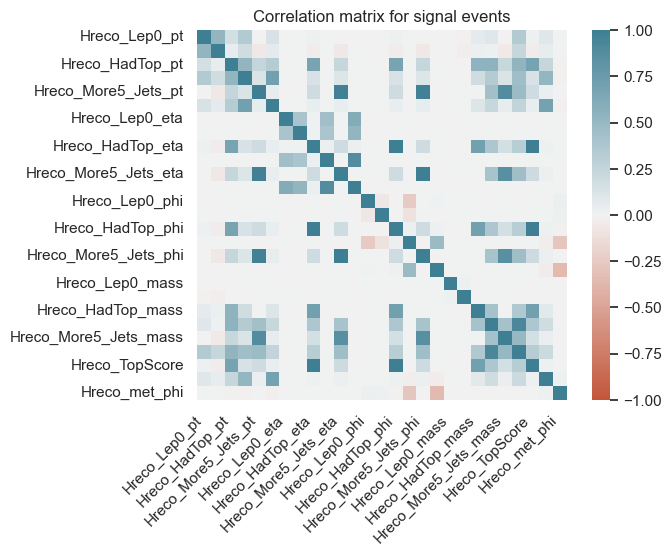

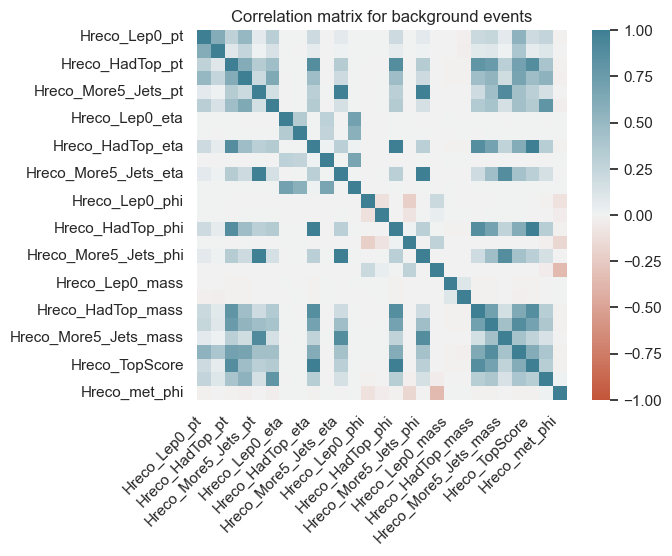

In [17]:
def corrmatrix(corr, label):
    ax = sns.heatmap(
        corr, 
        vmin=-1., vmax=1., center=0.,
        cmap=sns.diverging_palette(20., 220., n=200, as_cmap=True),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    );

    ax.set_title('Correlation matrix for %s events' % label)

    plt.show()


corrmatrix(X_train[y_train==1.].corr(), 'signal')
corrmatrix(X_train[y_train==0.].corr(), 'background')


What we have plotted is the Pearson correlation coefficient, which leads to an important limitation of this diagnostic tool.

The Pearson correlation coefficient captures only **linear** correlation between variables, and is blind to many nonlinear correlations that there may be. Don't trust the above matrices blindly.


![Figure from BDN2010](figs/corrcov.png)

(figure from C. Delaere slides at the 2010 BND school)

### Preprocess the data

Gradient minimization techniques like to mix numbers that are of the same order of magnitude and range.

In this data set, features are already scaled such that the range falls in the neighbourhood of unity. Sometimes this happens naturally, but in this case several variables come directly from particle physics and represent momenta of particles produced in high-energy interaction: when expressed in GeV, these variables will most certainly **not** be in a range close to unity. Therefore, we can infer that these few variables have already been preprocessed.

Common choices of preprocessing are minmax scaling or normalization.

###### Minmax

Compress the range linearly:

$$X_{scaled} = \frac{X-X_{min}}{X_{max}-X_{min}}$$

A drawback is that this results in an artificially smaller variance (the range is compressed linearly), which can deform the effect of outliers.

###### Standardization

Compress the range and the shape:

$$X_{normalized} = \frac{X - \mu}{\sigma}$$

where $\mu$ is the mean of the feature values and $\sigma$ is the standard deviation.

###### Which one?

Typically one would use minmax scaling when your features are remarkably nongaussian and your ML algorithm of choice doesn't require Gaussian inputs. The price is that it affects outliers.
Typically one would use normalization when the features are approximately Gaussian or when your ML algorithm of choice requires Gaussian inputs. However, it also results in numbers close to 1 (minimization algorithms and gradient descend love numbers that are not too large or too small), so it can be used for any algorithm: the good news is that it doesn't affect outliers.

For now, let's not apply any scaler.


### Build a simple tree-based classifier

The act of selecting regions of a data set by "cutting" (imposing thresholds) on some of the features is very natural for the particle physicist, so let's start by training a tree-based classifier.

Decision trees are precisely that:

<img src="figs/bdt_en_edit.png" alt="bdtexample" style="width:80%;"/>

(image from [r2d3.us](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/))

Decision trees depend however on the random order of imposing cuts on the data set. To reduce the dependence on the starting point and the ordering of the selection process, we will use an *ensemble* of decision trees, which will cut at random the data set, and we will *pool* the classification answers from all the trees via e.g. a majority vote.

Not all the trees resulting from the random cuts will make sense, so we will use a procedure called *boosting*, which consists in weighting each random tree based on its own performance. The weights will be used to decide how to generate the next trees.


<img src="figs/boosting.png" alt="boosting" style="width:80%;"/>


In [23]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

bdt_ada = AdaBoostClassifier(n_estimators=100, random_state=0)
bdt_grad = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=3, random_state=42)

In [24]:
print(X_train.shape, y_train.shape)


(1266862, 27) (1266862,)


In [51]:
# If it takes too much to run, try downsampling:
Ntrain=10000
Ntest=2000
X_train = X_train[:Ntrain]
y_train = y_train[:Ntrain]
X_test = X_test[:Ntest]
y_test = y_test[:Ntest]
fitted_bdt_ada=bdt_ada.fit(X_train, y_train)
fitted_bdt_grad=bdt_grad.fit(X_train, y_train)


/Users/vischia/workarea_temp/data_science_santiago_2024/machine_learning_tutorial/data_science_santiago_tutorial/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


<class 'pandas.core.frame.DataFrame'>


### Estimate the performance of the classifier

A simple performance estimate for the classifier is the mean accuracy on a certain data set.
Let's print it out for the training set and for the test set.

In [31]:
print('Adaptive boost: train score', fitted_bdt_ada.score(X_train, y_train),', test score', fitted_bdt_ada.score(X_test, y_test))
print('Gradient boost: train score', fitted_bdt_grad.score(X_train, y_train),', test score', fitted_bdt_grad.score(X_test, y_test                                                                                                        ))

Adaptive boost: train score 0.8579 , test score 0.832
Gradient boost: train score 0.9505 , test score 0.8095


We can observe two things:

For each dataset, the performance of gradient-based boosting is better than of adaptive boosting, which is normally expected.

For each algorithm, the performance on the test set is remarkably lower than that on the training set. Furthermore, the performance on the training set is very high. All of this is an indication that our algorithm is able to separate the two classes (signal and background) very effectively, but generalizes somehow poorly.

To study the generalization properties of machine learning algorithms we will switch to neural networks, where we can control in an intuitive way the complexity of the network.

For the moment, however, let's look at some additional ways of exploring the algorithm's performance.

#### ROC curve

In [32]:
def plot_rocs(scores_and_names, y):
    pack=[] 
    for s, n in scores_and_names: 
        fpr, tpr, thresholds = roc_curve(y.ravel(), s)
        pack.append([n, fpr,tpr,thresholds])

    plt.figure()
    lw=2
    for n, fpr, tpr, thresholds in pack:
        plt.plot(fpr, tpr, lw=lw, label="%s (AUC = %0.2f)" % (n, auc(fpr, tpr))) 

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic curve")
    plt.legend(loc="lower right")
    plt.show()

    
y_score = fitted_bdt_ada.decision_function(X_test)


Let's now plot the ROC curve for our two classifiers

/var/folders/_z/jj9k3dln24d4m13tc_cfv5dh0000gn/T/ipykernel_11629/3852147686.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, thresholds = roc_curve(y.ravel(), s)
/var/folders/_z/jj9k3dln24d4m13tc_cfv5dh0000gn/T/ipykernel_11629/3852147686.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  fpr, tpr, thresholds = roc_curve(y.ravel(), s)


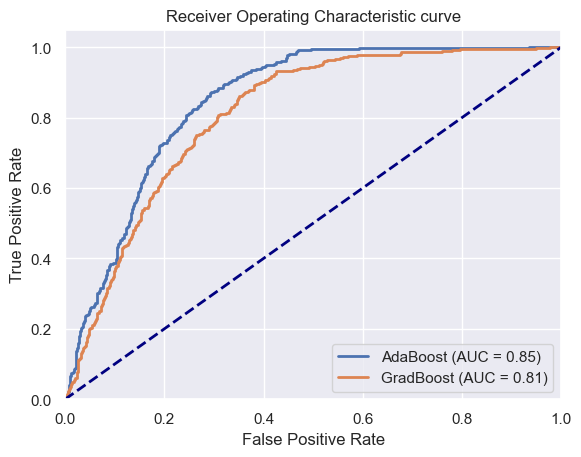

In [33]:
plot_rocs([ [fitted_bdt_ada.decision_function(X_test), 'AdaBoost'],
            [fitted_bdt_grad.decision_function(X_test), 'GradBoost']],
          y_test)

#### Inspection of the model

Plots the model structure and it correlation with a dataset.

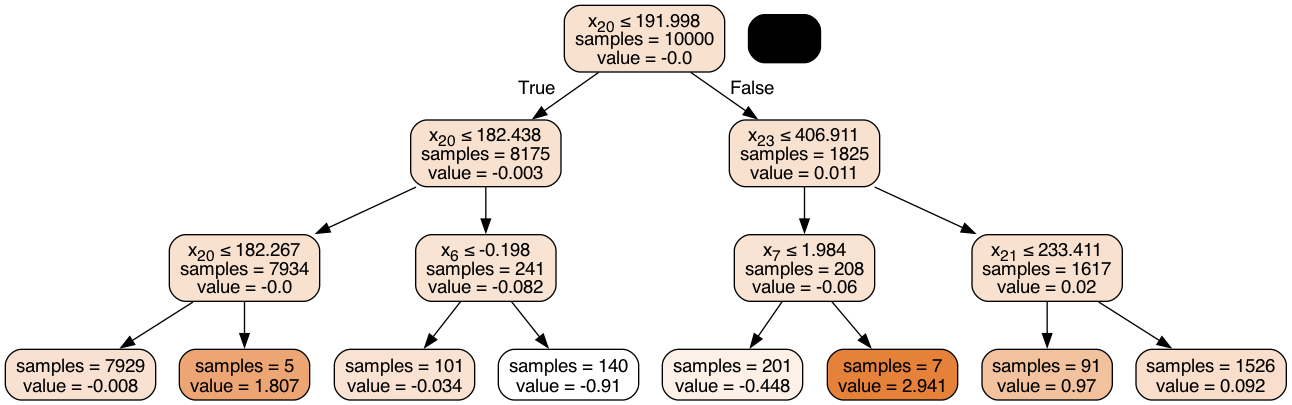

In [34]:
# Pick one of the trees (maybe modify to pick the tree with largest weight or something like that)
sub_tree_42 = fitted_bdt_grad.estimators_[42, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
Image(graph.create_png())

#### Explainability

A good question to pose yourself is whether the features you have chosen for your data are meaningful variables (i.e. if they are actually relevant to your classifier). Another good question is which features drive the prediction for a given event or set of events.

All these questions can be answered by using different concepts:

- **Permutation importance**: the decrease in a model score when a single feature value is randomly shuffled (scikit-learn docs) (akin to impacts for profile likelihood fits)
Shapley values: based on game theory (see other contribution)
Correlation-based: e.g. parallel coordinates in TMVA: look where each variable is mapped
to/correlated with

- **Perturbational approach**: perturbing the value of a feature and looking at the change of the prediction gives hints on how important the variable is for the method. This is at the basis of LIME (`pip install lime`). You can read more [here](https://www.oreilly.com/content/introduction-to-local-interpretable-model-agnostic-explanations-lime/)

- **Game-theoretical approach**: consider the prediction task as a game in game theory, and the features as players who bet via their values. The payout, as difference of prediction with respect to the true value, estimates how much a feature pushes the prediction away from the truth.

- **Visual approach**: parallel coordinates, which were implemented in ROOT TMVA, let you handily select a range in the prediction, and have a visual representation of which ranges of each feature is mapped into that region of the prediction.

![Parallel coordinates (reference in the figure)](figs/parcoord.png)

###### Permutation importance

The idea is: randomly shuffle one single feature value, then check how much does the prediction change. If the prediction decreases by a lot, then the value of the feature is crucial to the prediction.

Note: the importance is always **relative to a specific model**, it has no absolute validity. A feature that is deemed low-importance for a badly designed model may be deemed high-importance for a good model, and viceversa. Permutation importance scores don't "talk" across different models.

Also, if the model has a performance which is near-chance, then it is not strongly predictive, so the answers one may get from permutation importance scores are not really reliable.

In [37]:
scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

rs = permutation_importance(
    fitted_bdt_grad, X_test, y_test, n_repeats=30, random_state=0, scoring=scoring)

for metric in rs:
    print(f"{metric}")
    r = rs[metric]
    for i in r.importances_mean.argsort()[::-1]:
        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            print(f"    {X_train.columns[i]:<8}" # +1 to skip the label in the naming
                  f"{r.importances_mean[i]:.3f}"
                  f" +/- {r.importances_std[i]:.3f}")



r2
    Hreco_All5_Jets_pt0.302 +/- 0.032
    Hreco_Jets_plus_Lep_mass0.234 +/- 0.023
    Hreco_HadTop_pt0.225 +/- 0.029
    Hreco_Jets_plus_Lep_pt0.187 +/- 0.028
    Hreco_All5_Jets_mass0.152 +/- 0.027
    Hreco_TopScore0.151 +/- 0.027
    Hreco_met0.089 +/- 0.024
neg_mean_absolute_percentage_error
    Hreco_All5_Jets_pt191478044157035.438 +/- 16684436994020.867
    Hreco_Jets_plus_Lep_mass185398184660085.312 +/- 13389322794137.504
    Hreco_HadTop_pt143064348162802.656 +/- 14899739632533.951
    Hreco_Jets_plus_Lep_pt133231488976377.047 +/- 14812705151080.178
    Hreco_met99529551764887.891 +/- 12862225870112.270
    Hreco_All5_Jets_mass67929294379504.977 +/- 15827694987534.875
    Hreco_TopScore34152297174226.250 +/- 14266336122844.451
    Hreco_met_phi28297617658644.602 +/- 10411716733029.680
neg_mean_squared_error
    Hreco_All5_Jets_pt0.042 +/- 0.004
    Hreco_Jets_plus_Lep_mass0.033 +/- 0.003
    Hreco_HadTop_pt0.031 +/- 0.004
    Hreco_Jets_plus_Lep_pt0.026 +/- 0.004
    Hreco_A

Besides looking at the more important variables, you may also look at the less important, to **prune** them.

Pruning consists in dropping the least important variables and retraining your machine learning algorithm.
The idea behind it is that the variables dropped don't influence the prediction anyway, and retraining without them should give more or less the same performance but with a simpler model. Why would we do that? Well, for example inference may be time-sensitive, and simpler models are computationally **faster** to evaluate.

##### Shapley values
(based on [this blog post](https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/))

Shapley values are a construct based on game theory.
The main idea behind Shapley values is to consider the prediction task for a single event as game played by the feature values of that event. The features collaborate together to play the game by betting. The value of the feature is the amount each feature bets on the prediction task. The **Shapley Value** for each feature is the payout of the game, and consists in the correct weight such that the sum of all Shapley values for the features is the difference between the predictions and the average value of the model. In other words, the Shapley value represents how much each variable pushes the prediction far from the expected value.

More concretely, the Shapley value for a feature A is computed as follows:

- Get all subsets of features that do not contain A
- Compute the effect of adding A to each of these subsets 
- Aggregate all the contributions (i.e. compute the marginal contribution of the feature over all the subsets)

In principle we should retrain the model for each of these subsets, but instead we (the `shap` package, actually) will just compute predictions by replacing the value of the feature with its own average value.



In [53]:
shap.initjs()
explainer = shap.TreeExplainer(fitted_bdt_grad)
shap_values = explainer.shap_values(X_train)
i = 500
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

Values in blue represent features that push the prediction towards negative values, values in red represent features that push the prediction towards positive values, *for the event number 4776*.

We naturally want a summary of Shapley values over all observations:

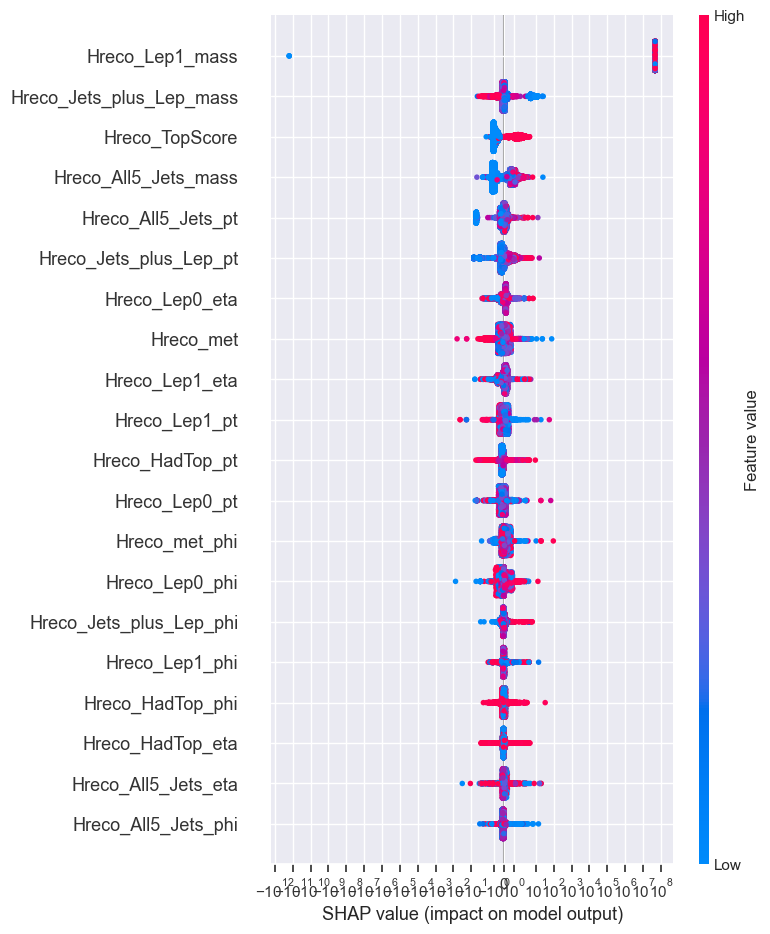

In [57]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, use_log_scale=True)

# EXERCISE: Variable preprocessing

Apply one of the scalers we have seen in class, or any other one from [this sklearn documentation page](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html).

Once you have imported the scaler (see cell below), you can just apply the transform method like so:

`std_scaled_X_train = StandardScaler().fit_transform(X)`. Make sure you apply this to both `X_train` and `X_test`

Then create BDTs what use the transformed data instead of the original data, train them, and compare their performance (for instance using the ROC curve seen above) with the BDTs that use the transformed data.

What is the result?

Now create a BDT that uses the original data passed through a PCA tranformation (again, the `fit_transform`method works well), and compare it with a BDT that uses the standarditez data passed through a PCA transformation. What can you say about performance?


In [61]:
from sklearn.preprocessing import (
    MaxAbsScaler, # maxAbs
    MinMaxScaler, # MinMax
    Normalizer, # Normalization (equal integral)
    StandardScaler# standard scaling
)
from sklearn.decomposition import PCA

### The end